### Simple parametric log spiral example
In theory, a logarithmic spiral pattern produces a cone/anticone surface (the Gaussian curvature is a delta function, vanishing everywhere away from the central singularity).
The total curvature is controlled by the spiral angle `alpha`.
In practice, the physical system smoothes out the curvature singularity.

In [1]:
import sys; sys.path.append('..')
import inflation, numpy as np, importlib
import fd_validation, visualization, parametric_pillows, wall_generation
import parallelism, benchmark
from numpy.linalg import norm

In [2]:
parallelism.set_max_num_tbb_threads(4)

In [4]:
from ipywidgets import interactive, widgets
def plotForAlpha(alpha): visualization.plot_line_segments(*parametric_pillows.logSpiralPlot(alpha=alpha, edgeLength=0.02, minDist=0.05, margin=.01))
iplot = interactive(plotForAlpha, alpha = widgets.FloatSlider(min=1, max=90, value=70, step=1))
iplot.children[-1].layout.height = '500px'
display(iplot)

interactive(children=(FloatSlider(value=70.0, description='alpha', max=90.0, min=1.0, step=1.0), Output(layout…

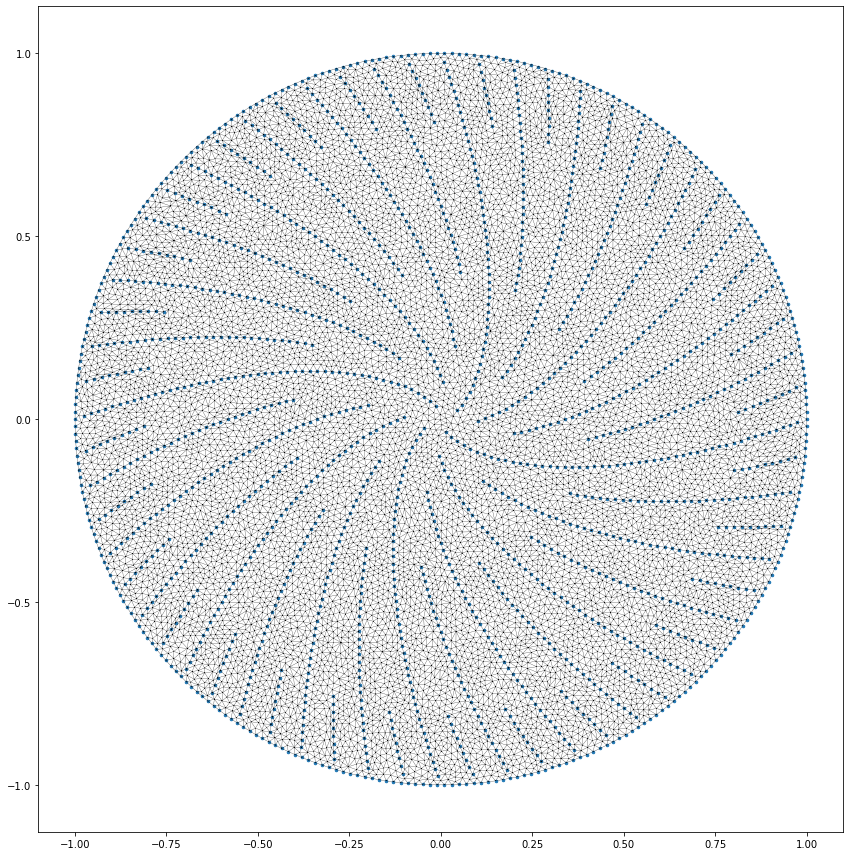

In [5]:
importlib.reload(parametric_pillows)
importlib.reload(visualization)
m, fuseMarkers, fuseEdges = wall_generation.triangulate_channel_walls(*parametric_pillows.logSpiralPlot(
                alpha=iplot.children[0].value, edgeLength=0.02, minDist=0.075, margin=0.025), 0.0002)
visualization.plot_2d_mesh(m, pointList=np.where(np.array(fuseMarkers) == 1)[0], width=12, height=12, )

In [6]:
isheet = inflation.InflatableSheet(m, np.array(fuseMarkers) != 0)

In [7]:
import py_newton_optimizer
isheet.setUseTensionFieldEnergy(True)
niter = 5000
iterations_per_output = 10
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-10
opts.niter = iterations_per_output

In [8]:
from tri_mesh_viewer import TriMeshViewer
viewer = TriMeshViewer(isheet.visualizationMesh(), width=1024, height=768)
viewer.showWireframe()
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [9]:
import time
isheet.pressure = 50
benchmark.reset()
for step in range(int(niter / iterations_per_output)):
    cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts)
    if cr.numIters() < iterations_per_output: break
    #isheet.writeDebugMesh('log_spiral_alpha_20/inflation_tf_step_{}.msh'.format(step))
    viewer.update(False, isheet.visualizationMesh())
    time.sleep(0.05) # Allow some mesh synchronization time for pythreejs
benchmark.report()

InflatableSheet setVars	0.038096	7
Newton iterations	65.8153	7
    InflatableSheet energy	0.00792313	7
    InflatableSheet gradient	0.013938	6
    Newton iterate	65.7903	68
        Backtracking	0.496583	67
            InflatableSheet energy	0.10116	98
            InflatableSheet setVars	0.387182	98
        Compute descent direction	65.0459	67
            newton_step	65.0454	67
                Newton solve	62.0894	116
                    CHOLMOD Numeric Factorize	54.7454	109
                    Solve	6.78737	71
                        CHOLMOD Backsub	0.867707	67
                        CHOLMOD Numeric Factorize	4.36526	7
                        CHOLMOD Symbolic Factorize	1.53794	7
                hessEval	2.54737	67
                largestMagnitudeEigenvalue	0.323421	5
        Preamble	0.217322	68
            Callback	6.50883e-05	68
            InflatableSheet energy	0.0625632	68
            InflatableSheet gradient	0.134699	68
Full time	67.1433


In [10]:
isheet.tensionStateHistogram()

[93, 5117, 43842]